In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout, Flatten ,BatchNormalization, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers , initializers
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

import os
import cv2
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers, losses, models
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
train_images = '/content/drive/MyDrive/Lab 7/archive/train/'
test_images = '/content/drive/MyDrive/Lab 7/archive/test/'

In [93]:
def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

In [94]:
Train_Count = Classes_Count(train_images, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_images, 'Test').transpose().sort_values(by="Test", ascending=False)
pd.concat([Train_Count, Test_Count], axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4107,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

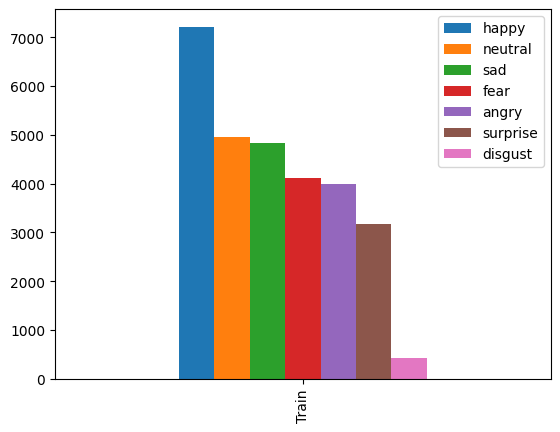

In [96]:
Train_Count.transpose().plot(kind='bar')

<Axes: >

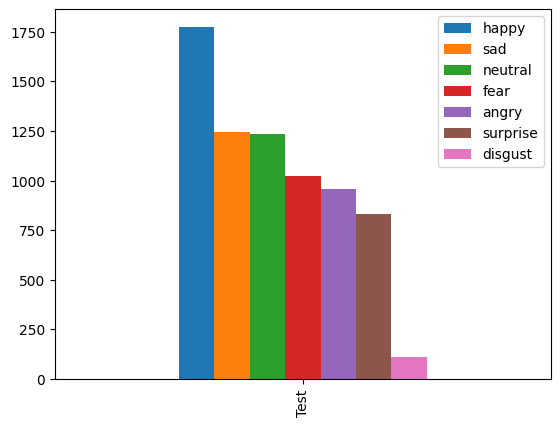

In [97]:
Test_Count.transpose().plot(kind='bar')

In [98]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, shear_range=0.15, zoom_range=0.1,
    brightness_range=[0.8,1.0], horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_images,
        target_size=(48,48),
        batch_size=32,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        test_images,
        target_size=(48,48),
        batch_size=32,
        color_mode="grayscale",
        class_mode='categorical')


Found 28719 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [99]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu',))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(7, activation='softmax'))


In [100]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

checkpoint = ModelCheckpoint("Facial_Expression_Recognition.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', save_best_only=True, verbose=1)

In [101]:
history = model.fit(
        train_generator,
        steps_per_epoch= len(train_generator),
        epochs=4,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks= [lr_reduction,checkpoint])

Epoch 1/4
898/898 [==============================] - ETA: 0s - loss: 2.0369 - accuracy: 0.2852
Epoch 1: val_accuracy improved from -inf to 0.31499, saving model to Facial_Expression_Recognition.h5
898/898 [==============================] - 1389s 2s/step - loss: 2.0369 - accuracy: 0.2852 - val_loss: 1.8901 - val_accuracy: 0.3150 - lr: 0.0010
Epoch 2/4
898/898 [==============================] - ETA: 0s - loss: 1.5466 - accuracy: 0.4144
Epoch 2: val_accuracy improved from 0.31499 to 0.40777, saving model to Facial_Expression_Recognition.h5
898/898 [==============================] - 625s 696ms/step - loss: 1.5466 - accuracy: 0.4144 - val_loss: 1.5480 - val_accuracy: 0.4078 - lr: 0.0010
Epoch 3/4
898/898 [==============================] - ETA: 0s - loss: 1.3938 - accuracy: 0.4671
Epoch 3: val_accuracy improved from 0.40777 to 0.50808, saving model to Facial_Expression_Recognition.h5
898/898 [==============================] - 583s 650ms/step - loss: 1.3938 - accuracy: 0.4671 - val_loss: 1.29

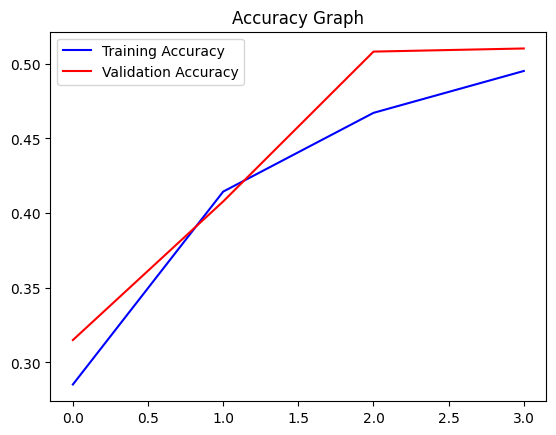

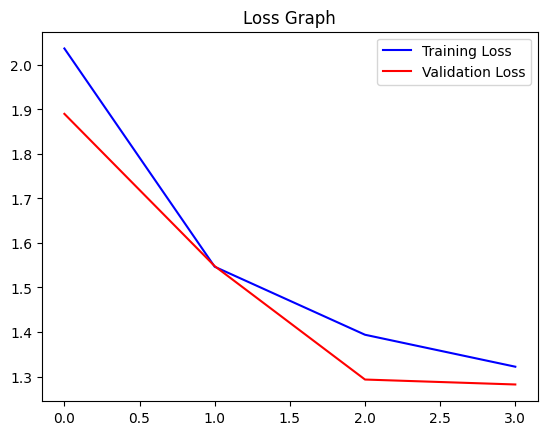

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

**Answer for the Bonus Question**

In [108]:

def build_ffnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [109]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [110]:
def build_rnn(input_shape, num_classes):
    model = models.Sequential([
        layers.SimpleRNN(64, input_shape=input_shape, return_sequences=True),
        layers.SimpleRNN(64),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
